## 3/12/24 - Analysing the grid cell specific calculation of the fixed relative humidity calculations

In [2]:
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
from scipy.stats import linregress, pearsonr, percentileofscore, norm
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
from multiprocessing import Pool, cpu_count
import time
import xskillscore as xs
import cartopy.crs as ccrs
f=2.3
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')


periods = ['historical', 'ssp245']
variables = ['tas', 'huss', 'ps']
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]
workingModels = np.array(modelNames.ModelName)
ds = xr.open_mfdataset([f'{model}_11_22.nc' for model in workingModels], coords='minimal', compat='override')
ds['residual'] = ds.d_tas_land - ds.d_tas_land_predict
ds = ds.chunk(dict(model=-1))
# ds = ds.load()
ds['corr'] = xr.corr(ds.gamma, ds.d_tas_land, dim='model')
ds['pval'] = xs.pearson_r_p_value(ds.gamma, ds.d_tas_land, dim='model', skipna=True)
ds['pval_ocean'] = xs.pearson_r_p_value(ds.d_tas_ocean, ds.d_tas_land, dim='model', skipna=True)
ds.model


<xarray.DataArray 'model' (model: 18)> Size: 1kB
array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2-WACCM',
       'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'GFDL-CM4', 'GFDL-ESM4',
       'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G', 'MIROC-ES2L',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL'],
      dtype='<U15')
Coordinates:
  * model    (model) <U15 1kB 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
    height   float64 8B ...

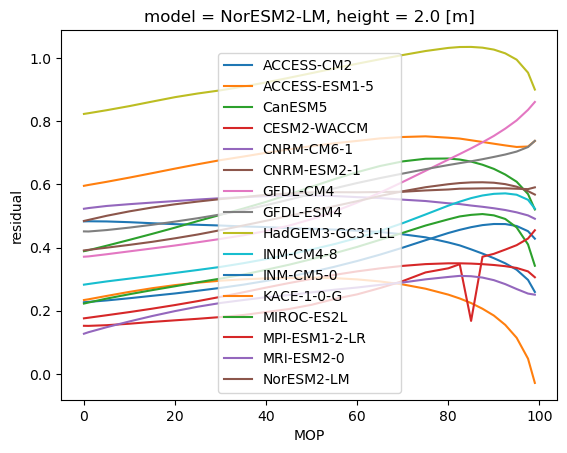

In [10]:
for model in workingModels:
    ds.residual.sel({'model':model}).mean(['lat', 'lon']).plot(label = model)
plt.legend()



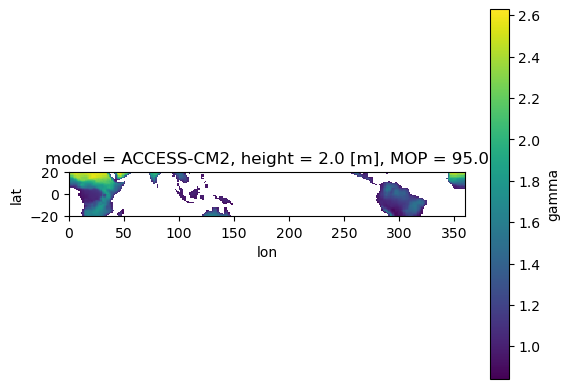

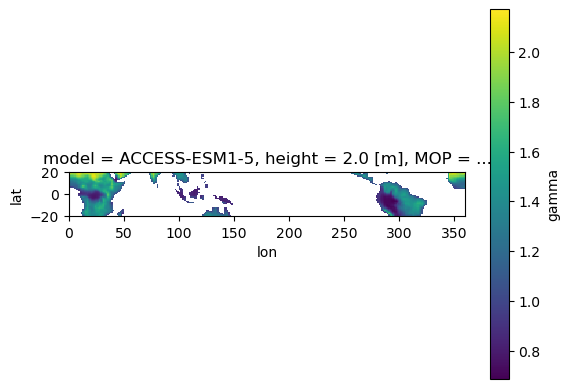

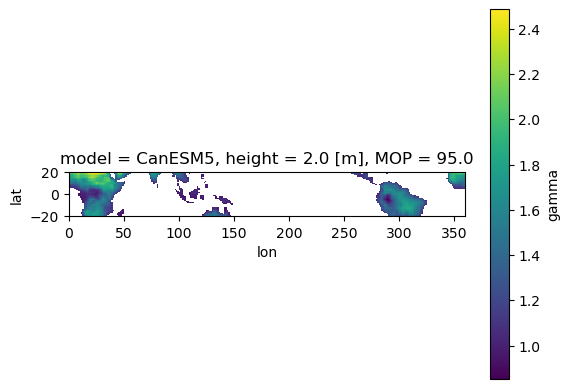

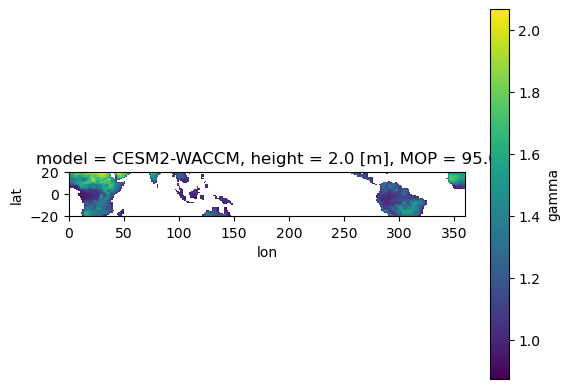

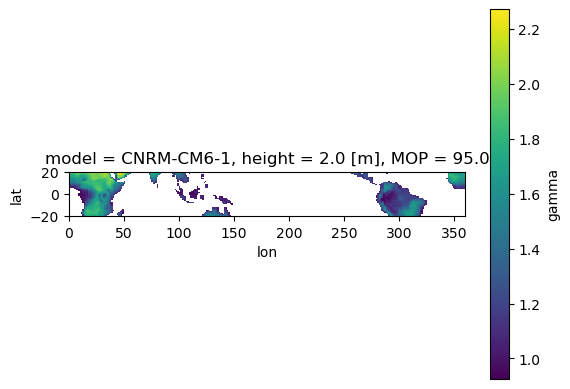

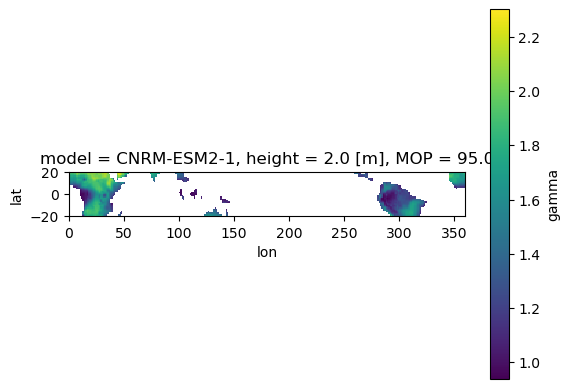

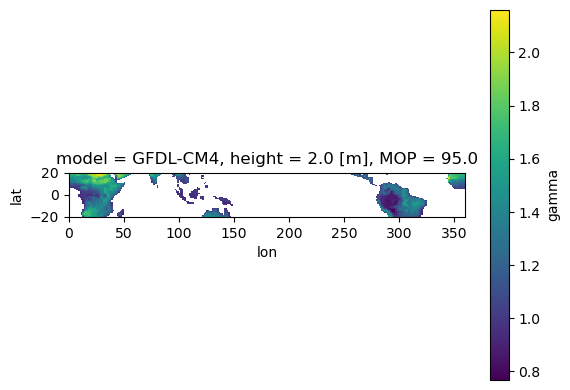

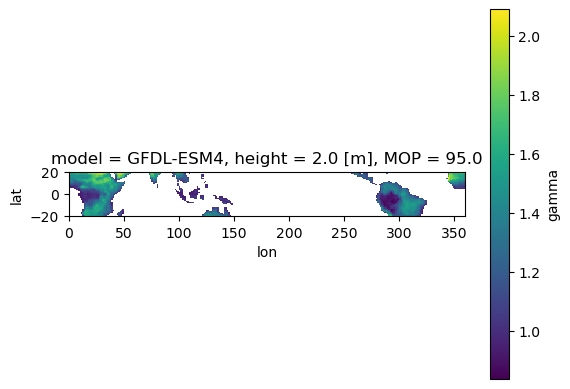

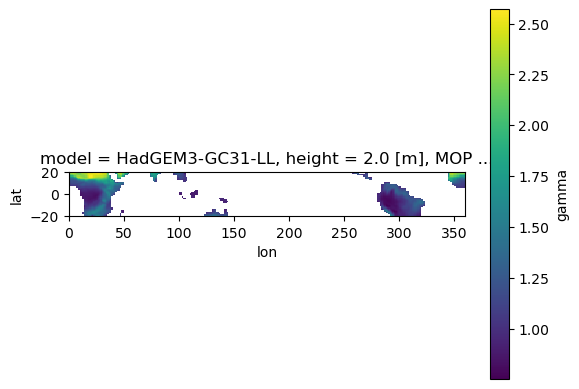

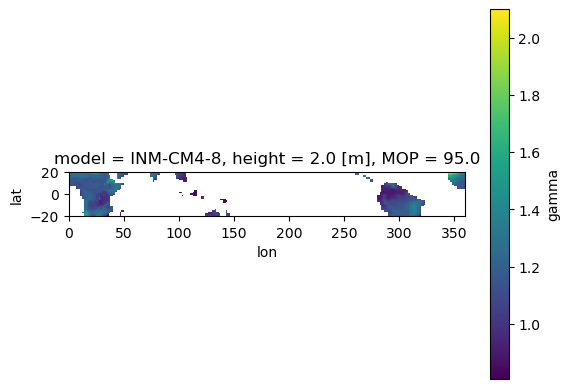

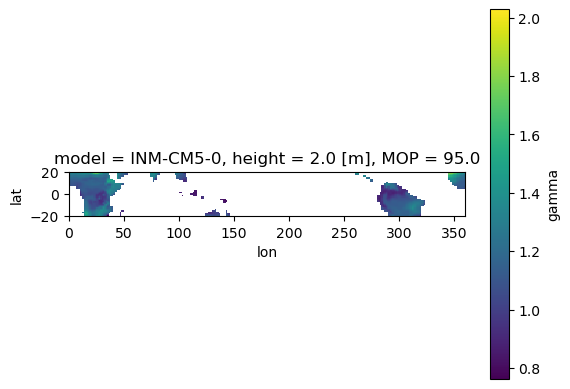

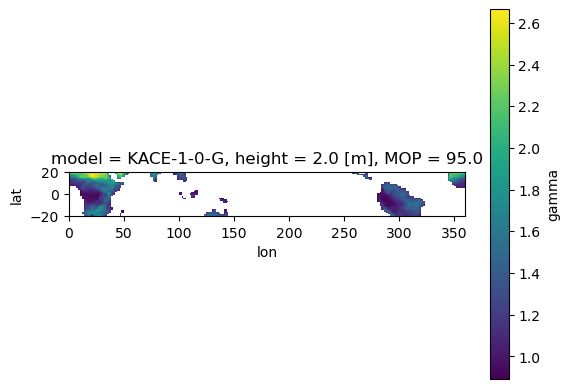

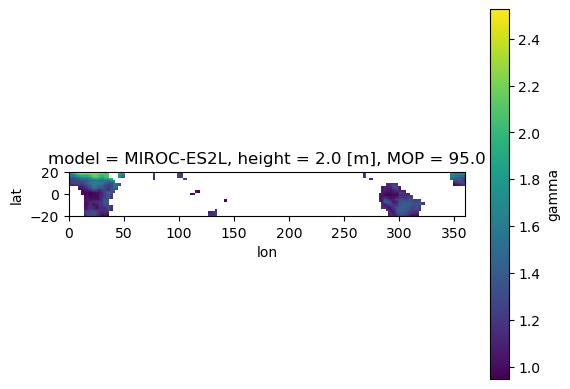

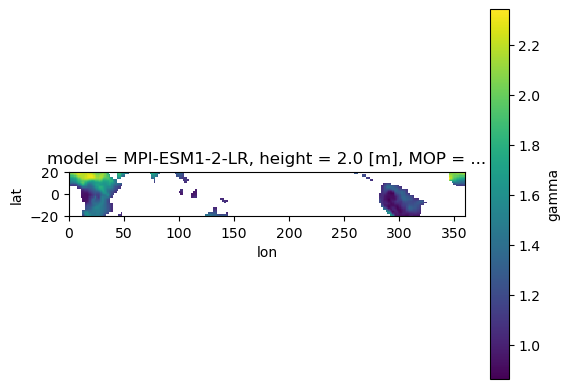

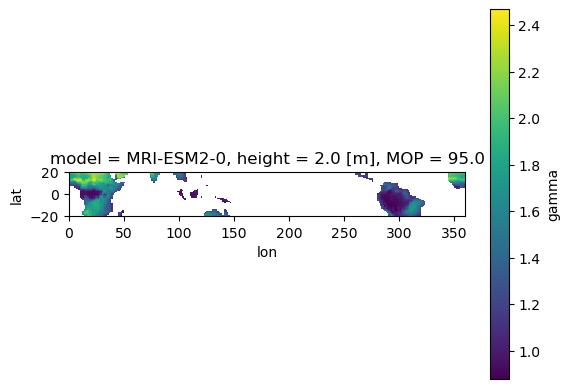

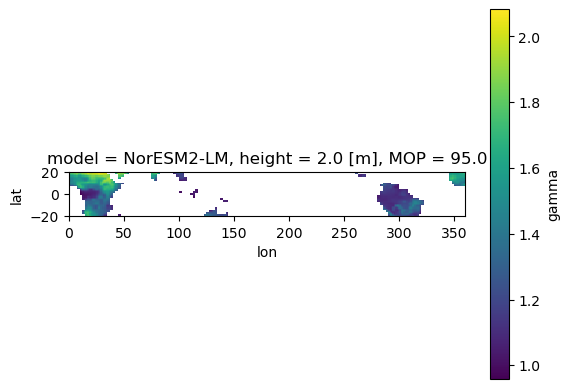

In [3]:
for model in workingModels:
    ds.gamma.sel({'MOP':95, 'model':model}).plot()
    plt.gca().set_aspect('equal')    
    plt.show()

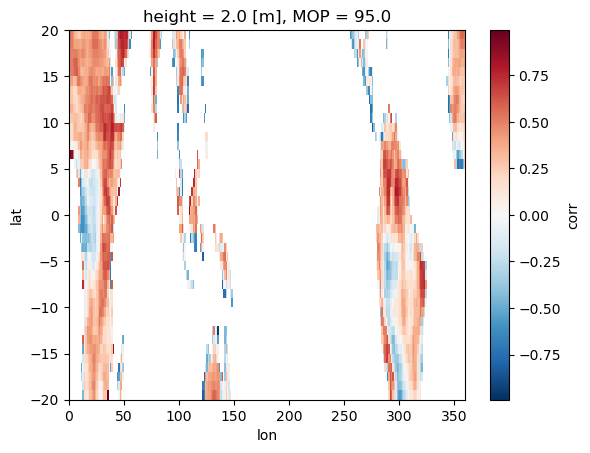

In [12]:
ds.corr.sel({'MOP':95}).plot()


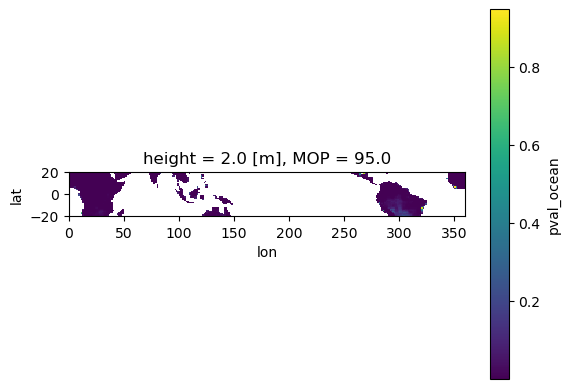

In [13]:
ds.pval_ocean.sel({'MOP':95}).plot()
plt.gca().set_aspect("equal")

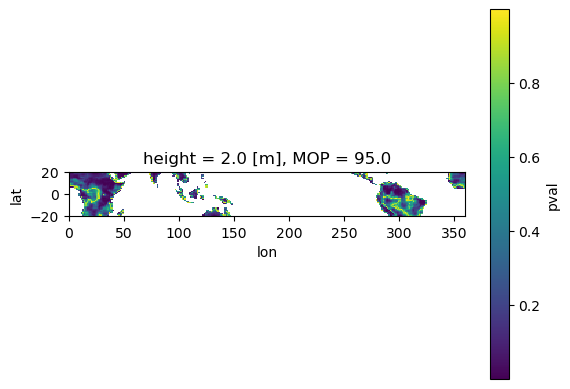

In [14]:
ds.pval.sel({'MOP':95}).plot()
plt.gca().set_aspect("equal")


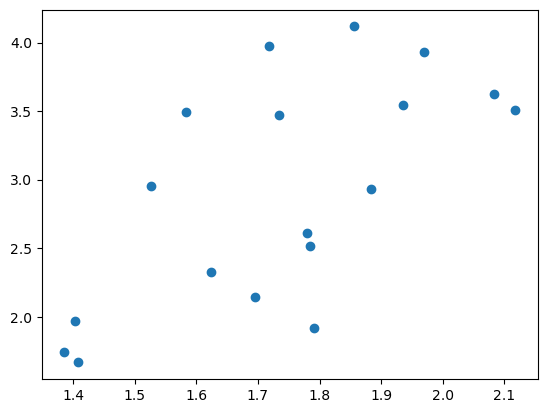

/home/users/chingosa/nb_envs/RCEMIP-Analysis/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/users/chingosa/nb_envs/RCEMIP-Analysis/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/users/chingosa/nb_envs/RCEMIP-Analysis/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/users/chingosa/nb_envs/RCEMIP-Analysis/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/users/chingosa/nb_envs/RCEMIP-Analysis/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/users/chingosa/nb_envs/RCEMIP-Analysis/lib/python3.11/

In [3]:
lats, lons = 10, 35
gamma = ds.gamma.sel(lat = lats, lon = lons, method = 'nearest').sel(MOP = 95) 
d_tas_land = ds.d_tas_land.sel(lat = lats, lon = lons, method = 'nearest').sel(MOP = 95)
plt.scatter(gamma, d_tas_land)

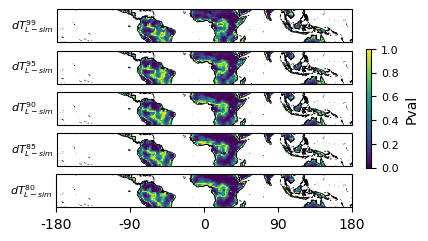

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
f = 2.3
# Parameters
var = 'pval'
vmin = 0
vmax = 1
mop_values = [99, 95, 90, 85, 80]  # Percentiles

# Create subplots with constrained layout
fig, axs = plt.subplots(
    5, 1, 
    figsize=(5*f, 1*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)

# Loop over MOP values to create plots
for i, (ax, MOP) in enumerate(zip(axs, mop_values)):
    data = ds[var].sel(MOP=MOP)
    
    # Plot the data
    im = ax.pcolormesh(
        ds.lon, ds.lat, data,
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        vmin=vmin, vmax=vmax
    )
    ax.coastlines(lw = 0.5)
    
    if i == len(mop_values) - 1:
        ax.set_xticks(range(-180, 181, 90), crs=ccrs.PlateCarree())
        ax.set_xticklabels(range(-180, 181, 90))
    
    # Add title on the side of each subplot
    ax.text(-0.01, 0.5, f"$dT^{{{MOP}}}_{{L-sim}}$", fontsize=8, transform=ax.transAxes, ha='right', va='center')

# Add a shared colorbar for all subplots
cbar = fig.colorbar(im, ax=axs, orientation='vertical', shrink=0.6, pad=0)
cbar.set_label("Pval", fontsize=10)
cbar.ax.tick_params(labelsize=10)

plt.show()


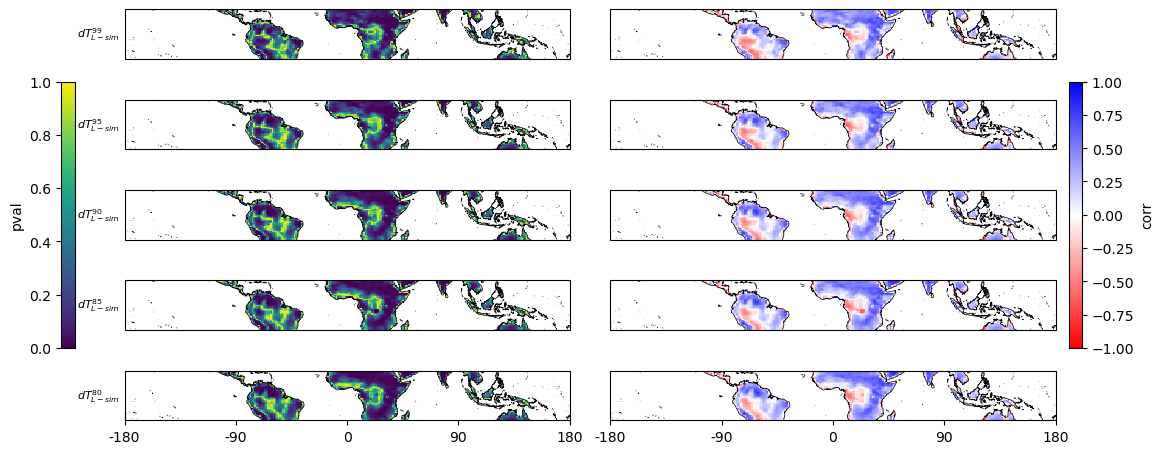

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
f = 2.3

mop_values = [99, 95, 90, 85, 80]  # Percentiles

# Create subplots with constrained layout
fig, axs = plt.subplots(
    5, 2, 
    figsize=(5*f, 2*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)

# Loop over MOP values to create plots
for j, var in enumerate(['pval', 'corr']):
    vmin = [0,-1][j]
    vmax = [1,1][j]
    
    for i, (ax, MOP) in enumerate(zip(axs[:,j], mop_values)):
        data = ds[var].sel(MOP=MOP)
        
        # Plot the data
        im = ax.pcolormesh(
            ds.lon, ds.lat, data,
            transform=ccrs.PlateCarree(),
            cmap=['viridis', 'bwr_r'][j],
            vmin=vmin, vmax=vmax
        )
        ax.coastlines(lw = 0.5)
        
        if i == len(mop_values) - 1:
            ax.set_xticks(range(-180, 181, 90), crs=ccrs.PlateCarree())
            ax.set_xticklabels(range(-180, 181, 90))
        
        # Add title on the side of each subplot
        if j == 0:
            ax.text(-0.01, 0.5, f"$dT^{{{MOP}}}_{{L-sim}}$", fontsize=8, transform=ax.transAxes, ha='right', va='center')
    
    # Add a shared colorbar for all subplots
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', shrink=0.6, pad=0, location = ['left', 'right'][j])
    cbar.set_label(var, fontsize=10)
    cbar.ax.tick_params(labelsize=10)
fig.title('')
plt.show()


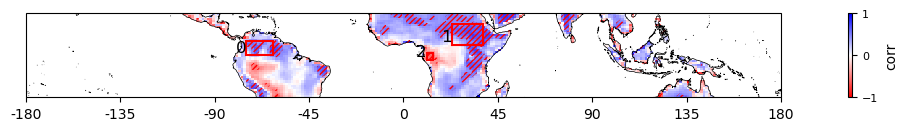

In [65]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches  # For drawing the rectangle
plt.rcParams['hatch.color'] = 'red'

# Parameters
density = 6
ds['isSignif'] = ds['pval'] < 0.05
f = 1.2
var = 'corr'
MOP = 95  # Example MOP value
vmin = -1
vmax = 1
colormap = 'bwr_r'  # Use this instead of selecting based on 'j'

# Create a plot
fig, ax = plt.subplots(
    1, 1, 
    figsize=(10*f, 1*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)

# Select data
data = ds[var].sel(MOP=MOP)

# Plot pcolormesh data
im = ax.pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap=colormap,
    vmin=vmin, vmax=vmax
)

# Add coastlines
ax.coastlines(linewidth=0.5)

# Overlay contour for significance
ax.contourf(
    ds.lon, ds.lat, ds['isSignif'].sel(MOP=95),
    transform=ccrs.PlateCarree(),
    colors='none', 
    levels=[0.5, 1.5],
    hatches=[density * '/', density * '/'])


## rect locations:
xStart = [285, 23,11]
yStart = [0, 5, -2]
xRun = [13, 15, 3]
yRun = [7, 10, 3]

for i in np.arange(len(xStart)):
    
    # Now you can create the rectangle with the adjusted longitudes
    rect = mpatches.Rectangle(
        (xStart[i], yStart[i]), 
        xRun[i], 
        yRun[i],
        linewidth=1.5, 
        facecolor='none', 
        edgecolor='red',
        transform=ccrs.PlateCarree()  # Ensure proper alignment
    )
    ax.text(xStart[i], yStart[i], i, horizontalalignment = 'right', verticalalignment = 'bottom',  fontsize=12,     transform=ccrs.PlateCarree())
    ax.add_patch(rect)
# Add a colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label(var, fontsize=10)
cbar.ax.tick_params(labelsize=8)
ax.set_xticks(range(-180, 181, 45), crs=ccrs.PlateCarree())
ax.set_xticklabels(range(-180, 181, 45))
plt.show()



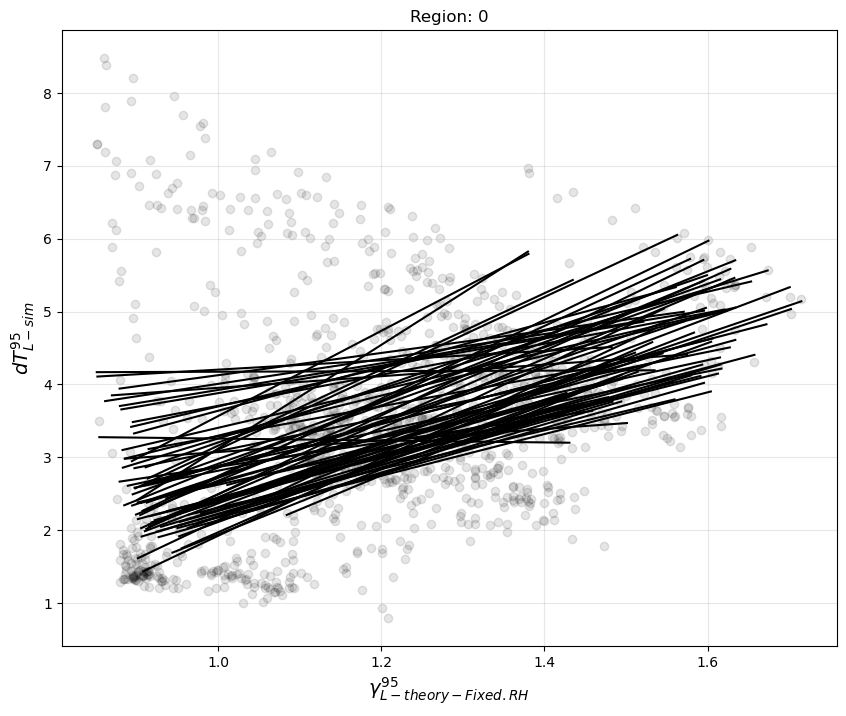

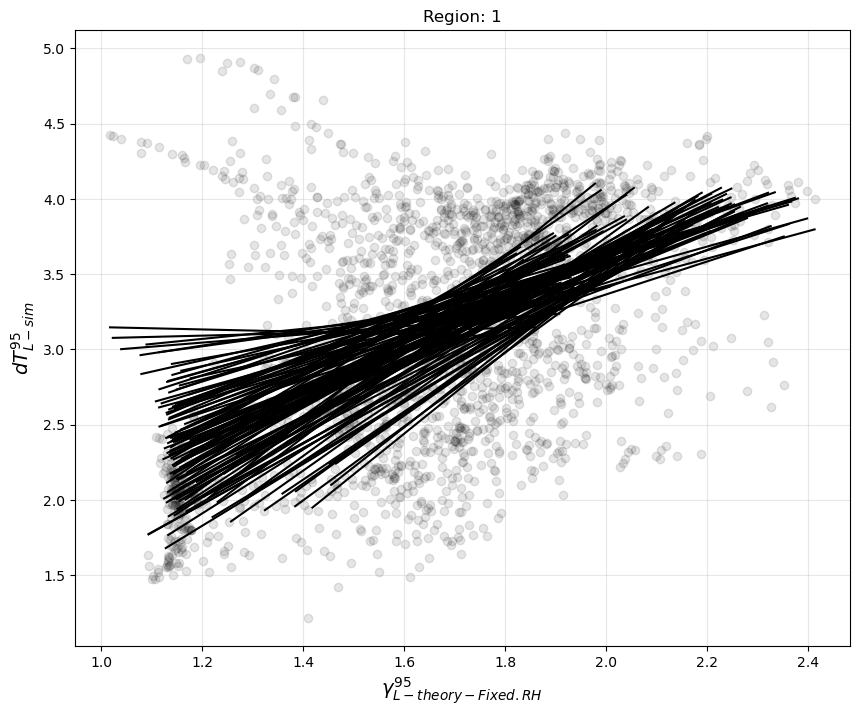

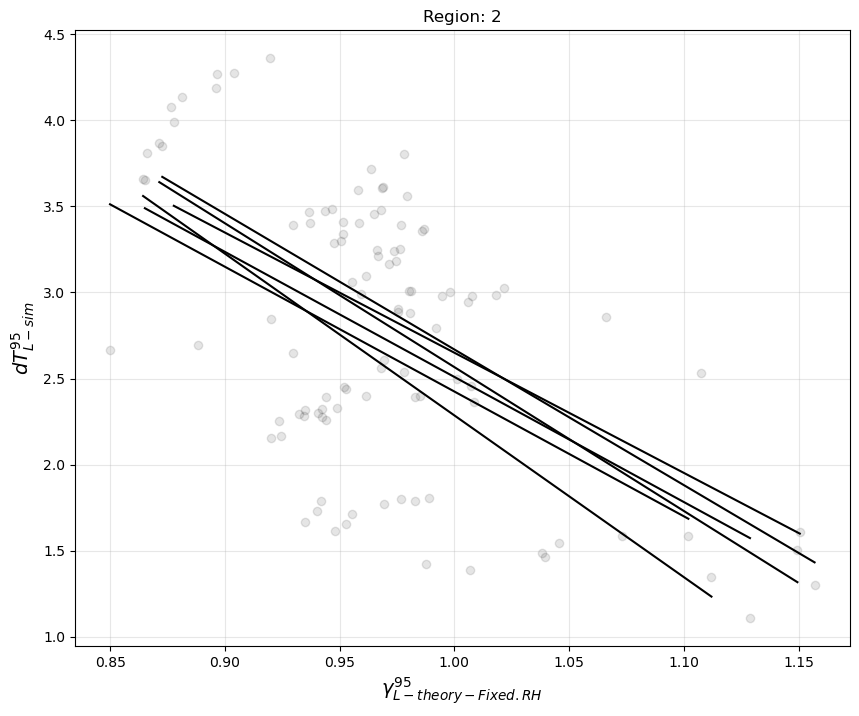

In [72]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import seaborn as sns
MOP = 95
for rect in np.arange(3):
    ds_sub = ds.sel(lon = slice(xStart[rect], xStart[rect] + xRun[rect]))
    ds_sub = ds_sub.sel(lat = slice(yStart[rect], yStart[rect] + yRun[rect]))
    mask = ~np.isnan(ds_sub.sel(MOP=MOP).gamma.values.flatten()) 
    
    # # Filter dataset
    # gamma_values_all = ds_sub.sel(MOP=MOP).gamma.values.flatten()[mask]
    # d_tas_land_values_all = ds_sub.sel(MOP=MOP).d_tas_land.values.flatten()[mask]
    
    # # Perform linear regression for all points
    # slope_all, intercept_all, r_value_all, p_value_all, std_err_all = linregress(gamma_values_all, d_tas_land_values_all)
    
    # # Generate best fit line for all points
    # x_fit_all = np.linspace(min(gamma_values_all), max(gamma_values_all), 100)
    # y_fit_all = slope_all * x_fit_all + intercept_all
    
    # Prepare the plot
    plt.figure(figsize=(10, 8))
    colors = sns.color_palette('Set2', len(ds_sub['lat']) * len(ds_sub['lon']))  # Generate a color palette
    
    # Loop through each model
    for loni in ds_sub['lon'].values:
        dta = ds_sub.sel(MOP=MOP, lon=loni)
        for lati in ds_sub['lat'].values:
            # Filter data for the current model
            gamma_values = dta.sel(lat=lati).gamma.values.flatten()
            d_tas_land_values = dta.sel(lat=lati).d_tas_land.values.flatten()
            
            # Remove NaNs
            mask = ~np.isnan(gamma_values) & ~np.isnan(d_tas_land_values)
            gamma_values = gamma_values[mask]
            d_tas_land_values = d_tas_land_values[mask]
            
            # Perform linear regression for the current model
            slope, intercept, r_value, p_value, std_err = linregress(gamma_values, d_tas_land_values)
            
            # Generate fitted line for the current model
            x_fit = np.linspace(min(gamma_values), max(gamma_values), 100)
            y_fit = slope * x_fit + intercept
            
            # Scatter plot and individual best fit line
            plt.scatter(gamma_values, d_tas_land_values, alpha=0.1, color = 'k')
            plt.plot(x_fit, y_fit, linestyle='-', color = 'k')
    
    # Plot best fit line for all points
    # plt.plot(x_fit_all, y_fit_all, color='black', linewidth=2, label=f"All Models (Best Fit)")
    
    # Add annotations
    plt.xlabel(f"$\gamma^{{{MOP}}}_{{L-theory - Fixed.RH}}$", fontsize=14)
    plt.ylabel(f"$dT^{{{MOP}}}_{{L-sim}}$", fontsize=14)
    # plt.legend(fontsize = 6, loc = 'lower right')
    plt.grid(alpha=0.3)
    plt.title(f'Region: {rect}')
    
    plt.show()


In [187]:

ds_sub

<xarray.Dataset> Size: 3MB
Dimensions:             (model: 18, lat: 8, lon: 15, MOP: 26)
Coordinates:
  * model               (model) <U15 1kB 'ACCESS-CM2' ... 'UKESM1-0-LL'
    height              float64 8B ...
  * lat                 (lat) float64 64B -12.5 -11.5 -10.5 ... -7.5 -6.5 -5.5
  * lon                 (lon) float64 120B 31.88 33.12 34.38 ... 48.12 49.38
  * MOP                 (MOP) float64 208B 0.001 1.0 5.0 10.0 ... 95.0 97.5 99.0
Data variables: (12/14)
    landseamask         (model, lat, lon) float64 17kB dask.array<chunksize=(18, 8, 15), meta=np.ndarray>
    latWeight           (model, lat) float64 1kB dask.array<chunksize=(18, 8), meta=np.ndarray>
    landFracWeight      (model, lat) float64 1kB dask.array<chunksize=(18, 8), meta=np.ndarray>
    d_tas_land          (model, lat, lon, MOP) float64 449kB dask.array<chunksize=(18, 8, 15, 26), meta=np.ndarray>
    d_tas_ocean         (model, lat, MOP) float64 30kB dask.array<chunksize=(18, 8, 26), meta=np.ndarray>
    gamma               (model, lat, MOP, lon) float64 449kB dask.array<chunksize=(18, 8, 26, 15), meta=np.ndarray>
    ...                  ...
    dfracland_ocean     (model, lat, lon, MOP) float64 449kB dask.array<chunksize=(18, 8, 15, 26), meta=np.ndarray>
    residual            (model, lat, lon, MOP) float64 449kB dask.array<chunksize=(18, 8, 15, 26), meta=np.ndarray>
    corr                (lat, MOP, lon) float64 25kB dask.array<chunksize=(8, 26, 15), meta=np.ndarray>
    pval                (lat, MOP, lon) float64 25kB dask.array<chunksize=(8, 26, 15), meta=np.ndarray>
    pval_ocean          (lat, MOP, lon) float64 25kB dask.array<chunksize=(8, 26, 15), meta=np.ndarray>
    isSignif            (lat, MOP, lon) bool 3kB dask.array<chunksize=(8, 26, 15), meta=np.ndarray>

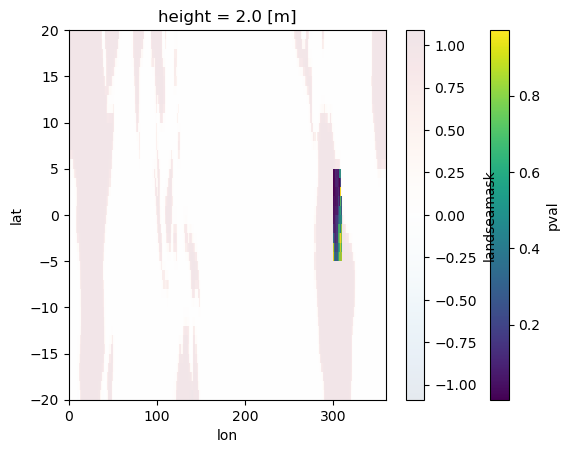

In [204]:

ds_sub.pval.sel(MOP=95).plot()
ds.landseamask.mean('model').plot(alpha = 0.1)
plt.show()

In [189]:
ds.sel(lat = slice(BottomLeft_l[rect][1], TopRight_l[rect][1]))

<xarray.Dataset> Size: 54MB
Dimensions:             (model: 18, lat: 8, lon: 288, MOP: 26)
Coordinates:
  * model               (model) <U15 1kB 'ACCESS-CM2' ... 'UKESM1-0-LL'
    height              float64 8B ...
  * lat                 (lat) float64 64B 7.5 8.5 9.5 10.5 11.5 12.5 13.5 14.5
  * lon                 (lon) float64 2kB 0.625 1.875 3.125 ... 358.1 359.4
  * MOP                 (MOP) float64 208B 0.001 1.0 5.0 10.0 ... 95.0 97.5 99.0
Data variables: (12/14)
    landseamask         (model, lat, lon) float64 332kB dask.array<chunksize=(18, 8, 288), meta=np.ndarray>
    latWeight           (model, lat) float64 1kB dask.array<chunksize=(18, 8), meta=np.ndarray>
    landFracWeight      (model, lat) float64 1kB dask.array<chunksize=(18, 8), meta=np.ndarray>
    d_tas_land          (model, lat, lon, MOP) float64 9MB dask.array<chunksize=(18, 8, 288, 26), meta=np.ndarray>
    d_tas_ocean         (model, lat, MOP) float64 30kB dask.array<chunksize=(18, 8, 26), meta=np.ndarray>
    gamma               (model, lat, MOP, lon) float64 9MB dask.array<chunksize=(18, 8, 26, 288), meta=np.ndarray>
    ...                  ...
    dfracland_ocean     (model, lat, lon, MOP) float64 9MB dask.array<chunksize=(18, 8, 288, 26), meta=np.ndarray>
    residual            (model, lat, lon, MOP) float64 9MB dask.array<chunksize=(18, 8, 288, 26), meta=np.ndarray>
    corr                (lat, MOP, lon) float64 479kB dask.array<chunksize=(8, 26, 288), meta=np.ndarray>
    pval                (lat, MOP, lon) float64 479kB dask.array<chunksize=(8, 26, 288), meta=np.ndarray>
    pval_ocean          (lat, MOP, lon) float64 479kB dask.array<chunksize=(8, 26, 288), meta=np.ndarray>
    isSignif            (lat, MOP, lon) bool 60kB dask.array<chunksize=(8, 26, 288), meta=np.ndarray>

/home/users/chingosa/nb_envs/RCEMIP-Analysis/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


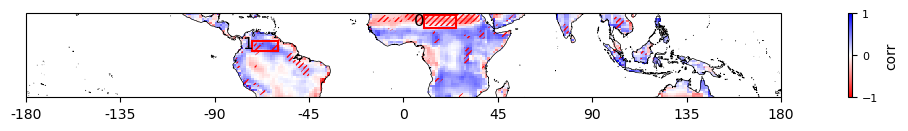

In [84]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches  # For drawing the rectangle
plt.rcParams['hatch.color'] = 'red'
ds['corr'] = xr.corr(ds.gamma, ds.dfracland_ocean, dim='model')
ds['pval'] = xs.pearson_r_p_value(ds.gamma, ds.dfracland_ocean, dim='model', skipna=True)
# Parameters
density = 6
ds['isSignif'] = ds['pval'] < 0.05
f = 1.2
var = 'corr'
MOP = 30  # Example MOP value
vmin = -1
vmax = 1
colormap = 'bwr_r'  # Use this instead of selecting based on 'j'
xStart = [10,288]
yStart = [13,2]
xRun = [15,12]
yRun = [6,5]

# Create a plot
fig, ax = plt.subplots(
    1, 1, 
    figsize=(10*f, 1*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)

# Select data
data = ds[var].sel(MOP=MOP)

# Plot pcolormesh data
im = ax.pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap=colormap,
    vmin=vmin, vmax=vmax
)

# Add coastlines
ax.coastlines(linewidth=0.5)

# Overlay contour for significance
ax.contourf(
    ds.lon, ds.lat, ds['isSignif'].sel(MOP=95),
    transform=ccrs.PlateCarree(),
    colors='none', 
    levels=[0.5, 1.5],
    hatches=[density * '/', density * '/'])

for i in np.arange(len(xStart)):
    
    # Now you can create the rectangle with the adjusted longitudes
    rect = mpatches.Rectangle(
        (xStart[i], yStart[i]), 
        xRun[i], 
        yRun[i],
        linewidth=1.5, 
        facecolor='none', 
        edgecolor='red',
        transform=ccrs.PlateCarree()  # Ensure proper alignment
    )
    ax.text(xStart[i], yStart[i], i, horizontalalignment = 'right', verticalalignment = 'bottom',  fontsize=12,     transform=ccrs.PlateCarree())
    ax.add_patch(rect)
# Add a colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label(var, fontsize=10)
cbar.ax.tick_params(labelsize=8)
ax.set_xticks(range(-180, 181, 45), crs=ccrs.PlateCarree())
ax.set_xticklabels(range(-180, 181, 45))
plt.show()



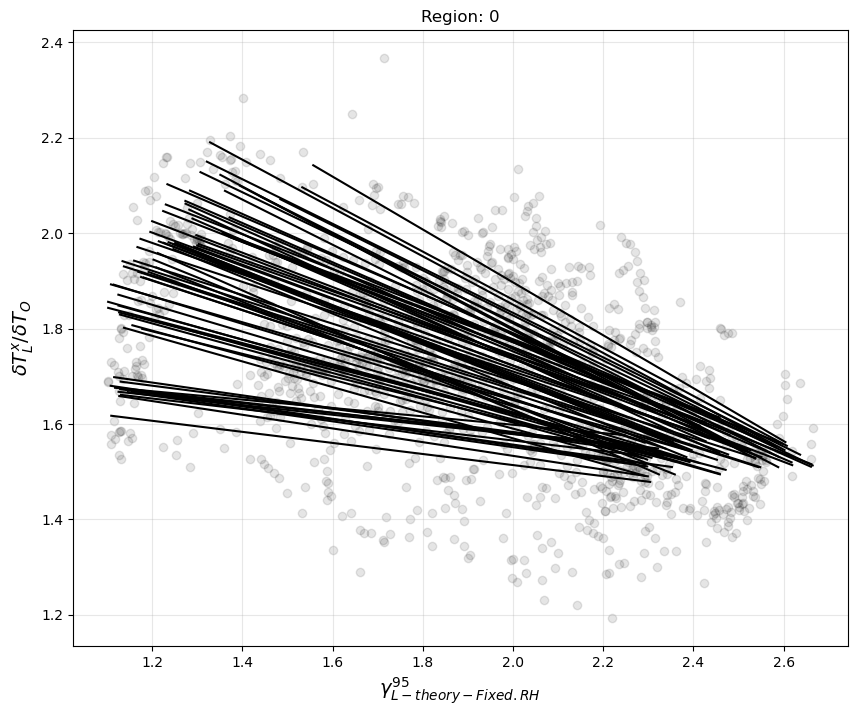

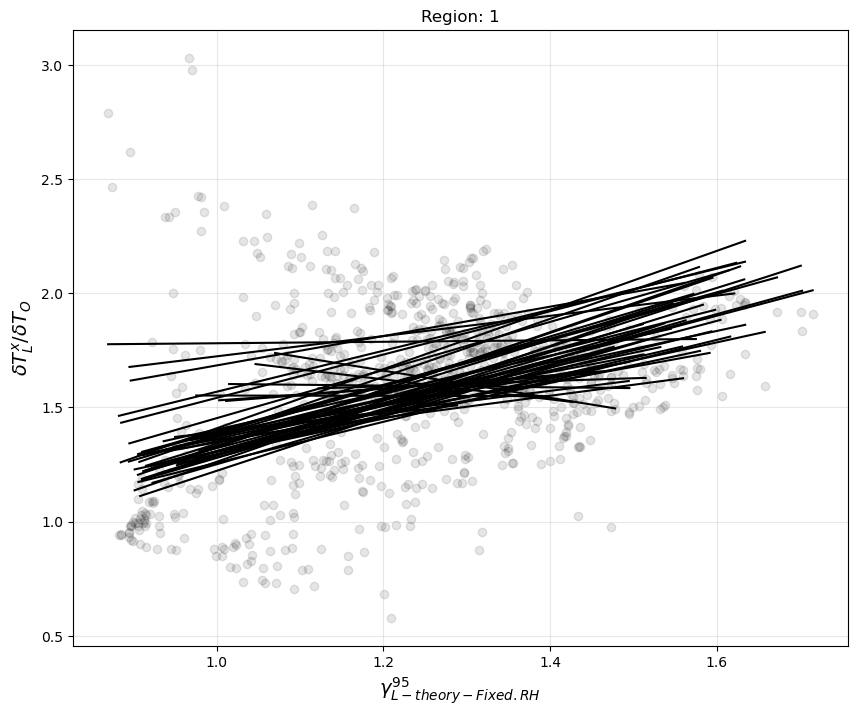

In [86]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import seaborn as sns
MOP = 95
for rect in np.arange(2):
    ds_sub = ds.sel(lon = slice(xStart[rect], xStart[rect] + xRun[rect]))
    ds_sub = ds_sub.sel(lat = slice(yStart[rect], yStart[rect] + yRun[rect]))
    mask = ~np.isnan(ds_sub.sel(MOP=MOP).gamma.values.flatten()) 
    
    # # Filter dataset
    # gamma_values_all = ds_sub.sel(MOP=MOP).gamma.values.flatten()[mask]
    # d_tas_land_values_all = ds_sub.sel(MOP=MOP).d_tas_land.values.flatten()[mask]
    
    # # Perform linear regression for all points
    # slope_all, intercept_all, r_value_all, p_value_all, std_err_all = linregress(gamma_values_all, d_tas_land_values_all)
    
    # # Generate best fit line for all points
    # x_fit_all = np.linspace(min(gamma_values_all), max(gamma_values_all), 100)
    # y_fit_all = slope_all * x_fit_all + intercept_all
    
    # Prepare the plot
    plt.figure(figsize=(10, 8))
    colors = sns.color_palette('Set2', len(ds_sub['lat']) * len(ds_sub['lon']))  # Generate a color palette
    
    # Loop through each model
    for loni in ds_sub['lon'].values:
        dta = ds_sub.sel(MOP=MOP, lon=loni)
        for lati in ds_sub['lat'].values:
            # Filter data for the current model
            gamma_values = dta.sel(lat=lati).gamma.values.flatten()
            d_tas_land_values = dta.sel(lat=lati).dfracland_ocean.values.flatten()
            
            # Remove NaNs
            mask = ~np.isnan(gamma_values) & ~np.isnan(d_tas_land_values)
            gamma_values = gamma_values[mask]
            d_tas_land_values = d_tas_land_values[mask]
            
            # Perform linear regression for the current model
            slope, intercept, r_value, p_value, std_err = linregress(gamma_values, d_tas_land_values)
            
            # Generate fitted line for the current model
            x_fit = np.linspace(min(gamma_values), max(gamma_values), 100)
            y_fit = slope * x_fit + intercept
            
            # Scatter plot and individual best fit line
            plt.scatter(gamma_values, d_tas_land_values, alpha=0.1, color = 'k')
            plt.plot(x_fit, y_fit, linestyle='-', color = 'k')
    
    # Plot best fit line for all points
    # plt.plot(x_fit_all, y_fit_all, color='black', linewidth=2, label=f"All Models (Best Fit)")
    
    # Add annotations
    plt.xlabel(f"$\gamma^{{{MOP}}}_{{L-theory - Fixed.RH}}$", fontsize=14)
    plt.ylabel(f"$\delta T_L^x / \delta T_O$", fontsize=14)
    # plt.legend(fontsize = 6, loc = 'lower right')
    plt.grid(alpha=0.3)
    plt.title(f'Region: {rect}')
    
    plt.show()


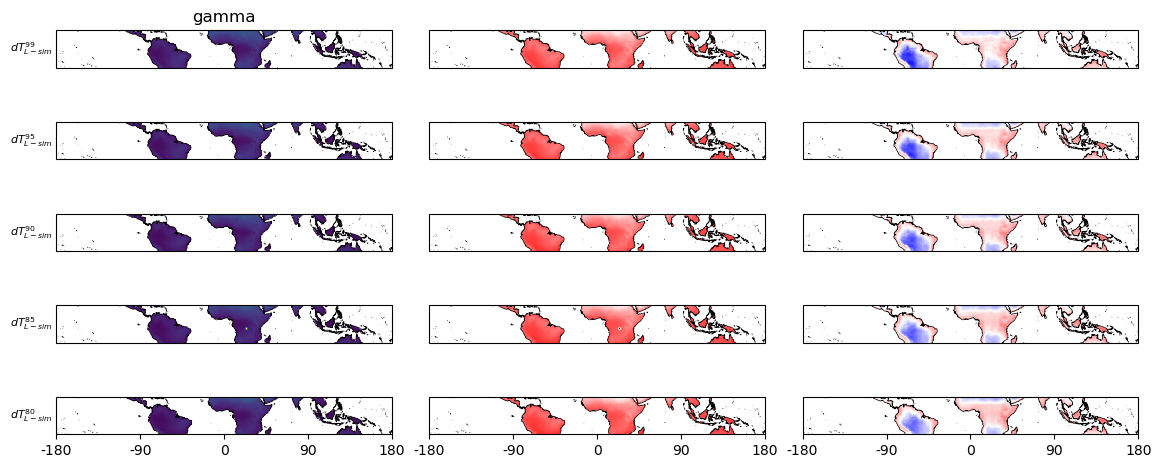

In [63]:
### Making a plot for mean gamma and mean Tchange for 

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
f = 2.3
ds.load()
mop_values = [99, 95, 90, 85, 80]  # Percentiles

# Create subplots with constrained layout
fig, axs = plt.subplots(
    5, 3, 
    figsize=(5*f, 2*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)
axs[0,0].set_title('gamma')

# Loop over MOP values to create plots
for j, var in enumerate(['gamma', 'd_tas_land_predict', 'd_tas_land']):
    vmin = ds[var].mean('model').min()
    vmax = ds[var].mean('model').max()
    for i, (ax, MOP) in enumerate(zip(axs[:,j], mop_values)):
        data = ds[var].sel(MOP=MOP).mean('model')
        
        # Plot the data
        im = ax.pcolormesh(
            ds.lon, ds.lat, data,
            transform=ccrs.PlateCarree(),
            cmap=['viridis', 'bwr_r', 'bwr_r'][j],
            vmin=vmin, vmax=vmax
        )
        ax.coastlines(lw = 0.5)
        
        if i == len(mop_values) - 1:
            ax.set_xticks(range(-180, 181, 90), crs=ccrs.PlateCarree())
            ax.set_xticklabels(range(-180, 181, 90))
        
        # Add title on the side of each subplot
        if j == 0:
            ax.text(-0.01, 0.5, f"$dT^{{{MOP}}}_{{L-sim}}$", fontsize=8, transform=ax.transAxes, ha='right', va='center')
    
    # Add a shared colorbar for all subplots
    # cbar = fig.colorbar(im, ax=axs, orientation='vertical', shrink=0.6, pad=0, location = ['left', 'none', 'right'][j])
    # cbar.set_label(var, fontsize=10)
    # cbar.ax.tick_params(labelsize=10)

# fig.title('')
plt.show()


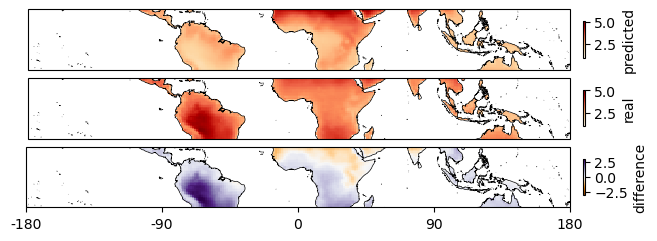

In [97]:
data = ds.d_tas_land.sel(MOP = 95).isel(model = 0)
data = ds.d_tas_land_predict.sel(MOP = 95).mean('model')
mn = np.min([ds.d_tas_land_predict.sel(MOP = 95).mean('model').min(), ds.d_tas_land.sel(MOP = 95).mean('model').min()])
mx = np.max([ds.d_tas_land_predict.sel(MOP = 95).mean('model').max(), ds.d_tas_land.sel(MOP = 95).mean('model').max()])
f = 2.3
fig, ax = plt.subplots(
    3, 1, 
    figsize=(10*f*3, 1*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)


# Plot pcolormesh data
im = ax[0].pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap='OrRd',
    vmin=mn, vmax=mx
)
cbar = fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=0.6, pad=0, location = 'right')
cbar.set_label('predicted', fontsize=10)
cbar.ax.tick_params(labelsize=10)

data = ds.d_tas_land.sel(MOP = 95).mean('model')
im = ax[1].pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap='OrRd',
    vmin=mn, vmax=mx
)
cbarr = fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=0.6, pad=0, location = 'right')
cbarr.set_label('real', fontsize=10)
cbarr.ax.tick_params(labelsize=10)

data = ds.residual.sel(MOP = 95).mean('model')
im = ax[2].pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap='PuOr',vmin=-3, vmax=3
)
cbarr = fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=0.6, pad=0, location = 'right')
cbarr.set_label('difference', fontsize=10)
cbarr.ax.tick_params(labelsize=10)
ax[2].set_xticks(range(-180, 181, 90), crs=ccrs.PlateCarree())
ax[2].set_xticklabels(range(-180, 181, 90))
ax[1].coastlines(linewidth=0.5)
ax[0].coastlines(linewidth=0.5)
ax[2].coastlines(linewidth=0.5)

plt.show()


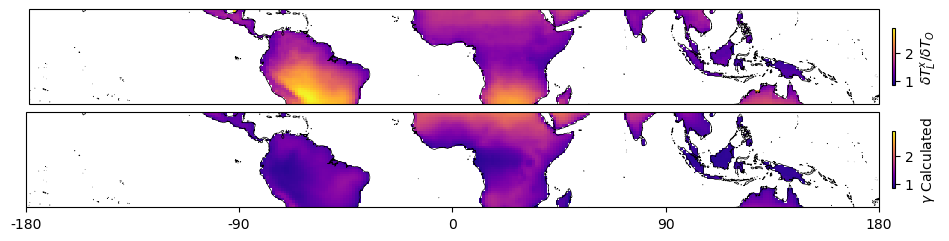

In [5]:
data = ds.dfracland_ocean.sel(MOP = 95).mean('model')
f = 2.3
mn = np.min([ds.dfracland_ocean.sel(MOP = 95).mean('model').min(), ds.gamma.sel(MOP = 95).mean('model').min()])
mx = np.max([ds.dfracland_ocean.sel(MOP = 95).mean('model').max(), ds.gamma.sel(MOP = 95).mean('model').max()])
fig, ax = plt.subplots(
    2, 1, 
    figsize=(10*f*2, 1*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)
# Plot pcolormesh data
im = ax[0].pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap='plasma',
    vmin=mn, vmax=mx
)
cbar = fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=0.6, pad=0, location = 'right')
cbar.set_label('$\delta T_L^x / \delta T_O$', fontsize=10)
cbar.ax.tick_params(labelsize=10)

data = ds.gamma.sel(MOP = 95).mean('model')

# Plot pcolormesh data
im = ax[1].pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap='plasma',
    vmin=mn, vmax=mx
)
cbar = fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=0.6, pad=0, location = 'right')
cbar.set_label('$\gamma$ Calculated', fontsize=10)
cbar.ax.tick_params(labelsize=10)
ax[1].coastlines(linewidth=0.5)
ax[0].coastlines(linewidth=0.5)
ax[1].set_xticks(range(-180, 181, 90), crs=ccrs.PlateCarree())
ax[1].set_xticklabels(range(-180, 181, 90))
plt.show()

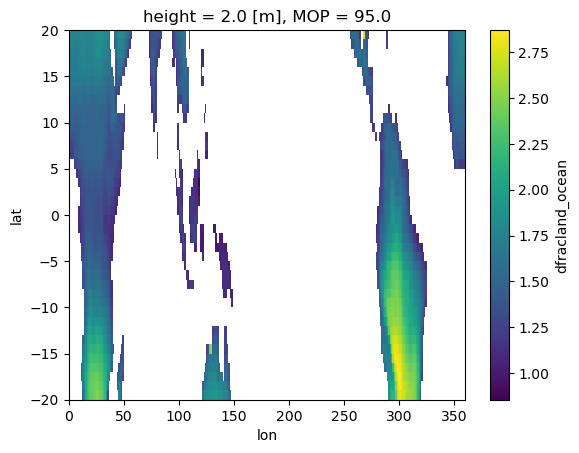

In [55]:
ds.dfracland_ocean.sel(MOP = 95).mean('model').plot()

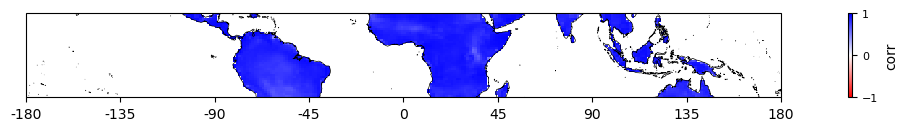

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches  # For drawing the rectangle
plt.rcParams['hatch.color'] = 'red'
ds['corr'] = xr.corr(ds.d_tas_ocean, ds.d_tas_land, dim='model')
ds['pval'] = xs.pearson_r_p_value(ds.d_tas_ocean, ds.d_tas_land, dim='model', skipna=True)
# Parameters
density = 6
ds['isSignif'] = ds['pval'] < 0.05
f = 1.2
var = 'corr'
MOP = 30  # Example MOP value
vmin = -1
vmax = 1
colormap = 'bwr_r'  # Use this instead of selecting based on 'j'
xStart = [10,288]
yStart = [13,2]
xRun = [15,12]
yRun = [6,5]

# Create a plot
fig, ax = plt.subplots(
    1, 1, 
    figsize=(10*f, 1*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)

# Select data
data = ds[var].sel(MOP=MOP)

# Plot pcolormesh data
im = ax.pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap=colormap,
    vmin=-1, vmax=1
)

# Add coastlines
ax.coastlines(linewidth=0.5)

# Overlay contour for significance
# ax.contourf(
#     ds.lon, ds.lat, ds['isSignif'].sel(MOP=95),
#     transform=ccrs.PlateCarree(),
#     colors='none', 
#     levels=[0.5, 1.5],
#     hatches=[density * '/', density * '/'])

# for i in np.arange(len(xStart)):
    
#     # Now you can create the rectangle with the adjusted longitudes
#     rect = mpatches.Rectangle(
#         (xStart[i], yStart[i]), 
#         xRun[i], 
#         yRun[i],
#         linewidth=1.5, 
#         facecolor='none', 
#         edgecolor='red',
#         transform=ccrs.PlateCarree()  # Ensure proper alignment
#     )
#     ax.text(xStart[i], yStart[i], i, horizontalalignment = 'right', verticalalignment = 'bottom',  fontsize=12,     transform=ccrs.PlateCarree())
#     ax.add_patch(rect)
# Add a colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label(var, fontsize=10)
cbar.ax.tick_params(labelsize=8)
ax.set_xticks(range(-180, 181, 45), crs=ccrs.PlateCarree())
ax.set_xticklabels(range(-180, 181, 45))
plt.show()



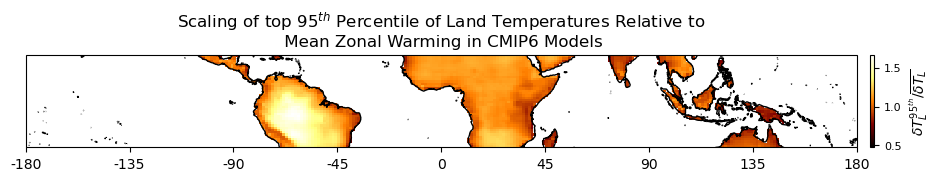

In [28]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches  # For drawing the rectangle

ds['landScaling'] = (ds.d_tas_land.sel(MOP = 95).mean('model') / ds.d_tas_land.isel(MOP = 0).mean(['model', 'lon',]))

f = 1.7

# Create a plot
fig, ax = plt.subplots(
    1, 1, 
    figsize=(10*f, 1*f), 
    subplot_kw={'projection': ccrs.PlateCarree()}, 
    layout="constrained"
)

# Select data
data = ds['landScaling']

# Plot pcolormesh data
im = ax.pcolormesh(
    ds.lon, ds.lat, data,
    transform=ccrs.PlateCarree(),
    cmap='afmhot',
)

# Add coastlines
ax.coastlines(linewidth=1)

cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.0)
cbar.set_label('$\delta T_L^{95^{th}} / \overline{\delta T_L}$', fontsize=10)
cbar.ax.tick_params(labelsize=8)
ax.set_xticks(range(-180, 181, 45), crs=ccrs.PlateCarree())
ax.set_xticklabels(range(-180, 181, 45))
ax.set_title('Scaling of top 95$^{th}$ Percentile of Land Temperatures Relative to \n Mean Zonal Warming in CMIP6 Models')
plt.show()

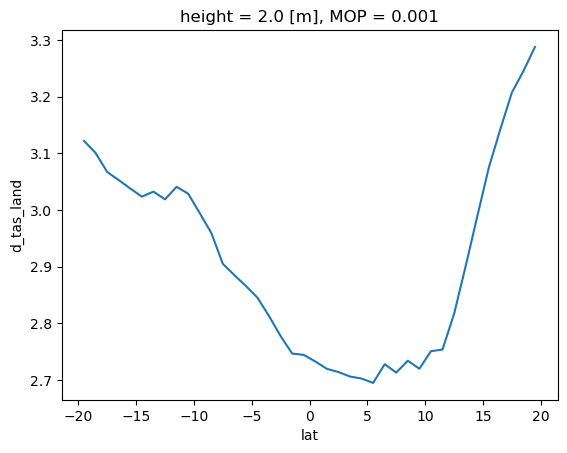

In [22]:
ds.d_tas_land.isel(MOP = 0).mean(['model', 'lon',]).plot()